## Optimizing a Paraboloid

* https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#gradients
* https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html
* https://openmdao.org/newdocs/versions/latest/examples/paraboloid.html

Find the minimum of

$$
f(x, y) = (x-3)^2 + xy + (y + 4)^2 - 3
$$

In [103]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
def show_f_2d(f, xy_range = (-50, 50)):
    x = np.linspace(*xy_range, 1000)
    y = np.linspace(*xy_range, 1000)
    
    xx, yy = np.meshgrid(x, y)
    zz = f(xx, yy)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.contour(xx, yy, zz, levels=np.linspace(np.min(zz), np.max(zz), 50))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Contour of f(x, y)', fontsize=18)
    plt.show()

In [11]:
def f(x, y):
    return (x - 3) ** 2 + x * y + (y + 4) ** 2 - 3

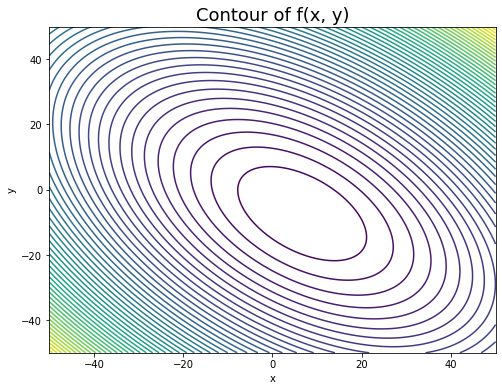

In [27]:
show_f_2d(f)

### Using OpenMDAO

In [36]:
prob = om.Problem()
prob.model.add_subsystem("paraboloid", om.ExecComp("f = (x-3)**2 + x*y + (y+4)**2 - 3"))

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options["optimizer"] = "SLSQP"

for design_var in ("x", "y"):
    prob.model.add_design_var(f"paraboloid.{design_var}", lower=-50, upper=50)

prob.model.add_objective("paraboloid.f")

prob.setup()

# initial_values
prob.set_val("paraboloid.x", 3)
prob.set_val("paraboloid.y", -4)

prob.run_driver()

Optimization terminated successfully    (Exit mode 0)
            Current function value: [-27.33333333]
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------


False

In [38]:
for val in ("x", "y", "f"):
    print(prob.get_val(f"paraboloid.{val}"))

[6.66666667]
[-7.33333333]
[-27.33333333]


### Using JAX

In [114]:
from jax import grad

In [120]:
def optimize(f, x, learning_rate=0.05, steps=70):
    
    # argnums=(0, 1) means that grad_f(*)
    # returns a tuple of two values containing both
    # df/dx(x, y) and df/dy(x, y)
    grad_f = grad(f, argnums=(0, 1))
    
    for i in range(steps):
        
        # [df/dx(x, y), df/dy(x, y)]
        current_grad = np.array(grad_f(*x))

        # update current position by x - 
        x -= current_grad * learning_rate
        if i % 10 == 0:
            print(f"step={i}, x={x}, f(x)={f(*x)}")

In [121]:
optimize(f, (3., -4.))

step=0, x=[ 3.2  -4.15], f(x)=-16.2175
step=10, x=[ 4.6479758  -5.37042355], f(x)=-23.367713760638015
step=20, x=[ 5.46921004 -6.14685857], f(x)=-25.912460671353845
step=30, x=[ 5.95191175 -6.62074047], f(x)=-26.823999406067752
step=40, x=[ 6.23915092 -6.90624324], f(x)=-27.150745411513284
step=50, x=[ 6.41078272 -7.07753319], f(x)=-27.26787817720495
step=60, x=[ 6.51347634 -7.1801595 ], f(x)=-27.309868582996202


## Using Scipy

In [123]:
import scipy.optimize

In [125]:
scipy.optimize.minimize(lambda x: f(*x), x0=(3, -4))

      fun: -27.333333333333314
 hess_inv: array([[ 0.66666666, -0.33333338],
       [-0.33333338,  0.66666657]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 6.6666668, -7.3333335])